# Exercise 6: Firm growth with interactivity

## Section 1: Defining the model


1. **Partner Selection:** Firms interact if their relative size meets the following condition:
$$ \frac{1}{\delta} \cdot x_i \leq x_j \leq \delta \cdot x_i $$
When implementing this condition take the perspective of a firm looking for a partner.
Sampling two firms $i$ and $j$ from the population at random and checking the condition is very inefficient.


2. **Transaction Dynamics:** The winning probability in a transaction between firms $i$ and $j$ is:
$$ P(i \text{wins}) = \frac{x_i}{x_i + x_j} $$


3. **Resource Exchange:** Upon winning, "resources", i.e. part of their size are transferred from the loser to the winner. The amount of resources transferred is $ x_\text{loser} \gamma$ and  $\gamma \in [0, 1]$


In [1]:
import numpy as np
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa import DataCollector

In [87]:
class Firm(Agent):
    """A Firm agent with a given size, part of an economic model."""

    def __init__(self, unique_id: int, model: "FirmModel", size: float):
        super().__init__(unique_id, model)
        self.size = size

    def step(self) -> None:
        # your agent's actions
        partner = self.select_partner()
        if partner:
            win_prob = self.calculate_win_probability(partner)
            outcome = self.random.random()
            if outcome > win_prob:
                self.pay(partner)
            else:
                partner.pay(self)

    def calculate_win_probability(self, partner: "Firm") -> float:
        # compute the win probability based on the size of the two firms
        if self.model.large_firm_advantage:
            return self.size/(self.size+partner.size)
        else:
            return partner.size/(self.size+partner.size)

    def pay(self, partner: "Firm") -> None:
        """Transfer a fraction of the firm's size to a partner firm."""
        partner.size+=self.model.gamma*self.size
        self.size-=self.model.gamma*self.size

    def select_partner(self):
        """Select an other firm from the model that is within this firm's size interval (self) and return it."""
        partner = self.model.firms[0]
        i=1
        while self.size/partner.size >= self.model.delta or self.size/partner.size <= 1/self.model.delta or partner == self:
            rnd_sample = np.random.randint(0,len(self.model.firms))
            if i>=2*len(self.model.firms):
                return None # Timeout
            partner = self.model.firms[rnd_sample]
            i+=1
        return partner


class FirmModel(Model):
    """A model simulating an economy with a variable number of firms."""

    def __init__(
        self,
        N: int,
        mu: float,
        sigma: float,
        delta: float,
        gamma: float,
        large_firm_advantage: bool = True,
    ):
        super().__init__()
        self.num_agents = N
        self.delta = delta
        self.gamma = gamma
        self.large_firm_advantage = large_firm_advantage
        self.schedule = RandomActivation(self)
        self.firms = []

        for i in range(self.num_agents):
            size = np.random.lognormal(mu, sigma)
            firm = Firm(i, self, size)
            self.schedule.add(firm)
            self.firms.append(firm)

        self.datacollector = DataCollector(
            agent_reporters={"Size": lambda a: a.size},
            model_reporters={"Firm_sizes": lambda m: m.firm_sizes()},
        )

    def firm_sizes(self) -> np.ndarray:
        return np.array([firm.size for firm in self.firms])

    def step(self) -> None:
        self.datacollector.collect(self)
        self.schedule.step()


In [88]:
import matplotlib.pyplot as plt

from tqdm import tqdm, trange
import random

# Example usage
N = 1000  # Number of firms
m = 6.0  # Mean of the log-normal distribution
s = 1.5  # Standard deviation of the log-normal distribution
delta = 2  # Range factor for interaction
gamma = 0.1  # Size exchange in interactions
max_steps = 500
# set seed for reproducibility
np.random.seed(0)
random.seed(0)
large_firm_model = FirmModel(N, m, s, delta, gamma, large_firm_advantage=True)

for _ in trange(max_steps):
    large_firm_model.step()

firm_sizes = large_firm_model.datacollector.get_model_vars_dataframe()["Firm_sizes"].to_numpy()

100%|██████████| 500/500 [00:10<00:00, 45.56it/s]


In [89]:
def plot_firm_evolutions(firm_sizes, max_steps, model):
    firm_sizes = np.array([np.array(element) for element in firm_sizes])

    assert firm_sizes.shape == (max_steps, len(model.firms))

    plt.figure()
    for i in range(len(firm_sizes[0])):
        plt.plot(firm_sizes[:,i])
    plt.yscale("log")
    plt.show()

In [90]:
def plot_firm_sizes(firm_sizes):
    plt.figure()
    plt.hist(np.log(firm_sizes), bins=100)
    plt.show()

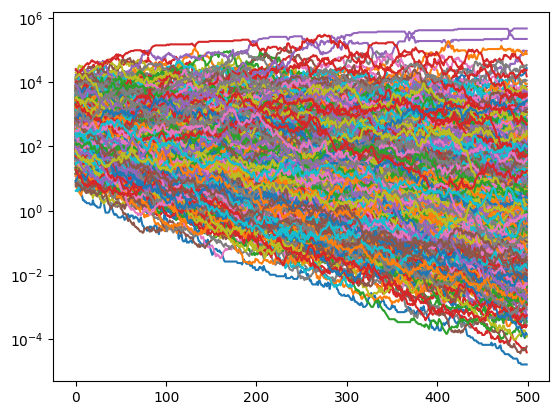

In [91]:
plot_firm_evolutions(firm_sizes, max_steps, large_firm_model)

## Section 2: Adapt the model such that the smaller firm has a higher winning probability.

In [92]:
# Added boolean parameter in original model

## Run the simulation with the following parameters:

In [93]:
from tqdm import tqdm, trange
import random

# Example usage
N = 1000  # Number of firms
m = 6.0  # Mean of the log-normal distribution
s = 1.5  # Standard deviation of the log-normal distribution
delta = 2  # Range factor for interaction
gamma = 0.1  # Size exchange in interactions
max_steps = 500

# set seed for reproducibility
np.random.seed(0)
random.seed(0)
small_firm_model = FirmModel(N, m, s, delta, gamma, large_firm_advantage=False)

for i in trange(max_steps):
    small_firm_model.step()

small_model_firm_sizes = small_firm_model.datacollector.get_model_vars_dataframe()["Firm_sizes"].to_numpy()

100%|██████████| 500/500 [00:06<00:00, 79.11it/s]


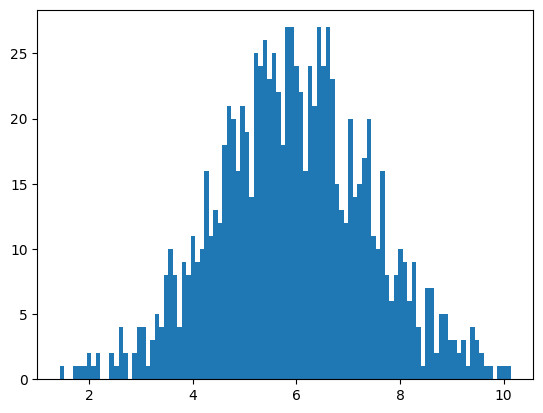

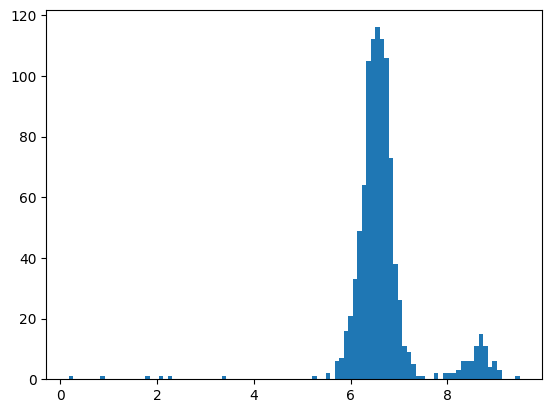

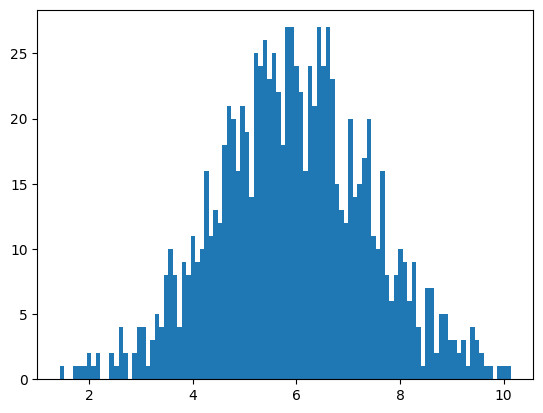

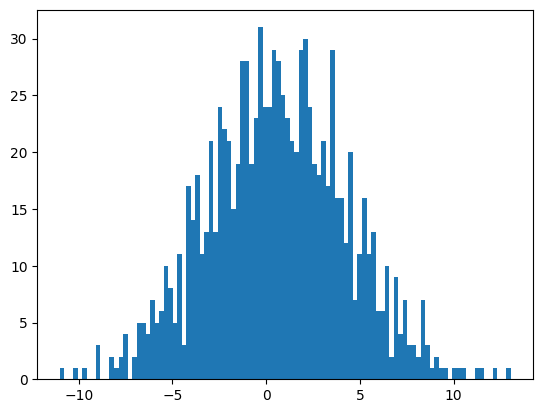

In [94]:
plot_firm_sizes(small_model_firm_sizes[0])
plot_firm_sizes(small_model_firm_sizes[-1])
plot_firm_sizes(firm_sizes[0])
plot_firm_sizes(firm_sizes[-1])

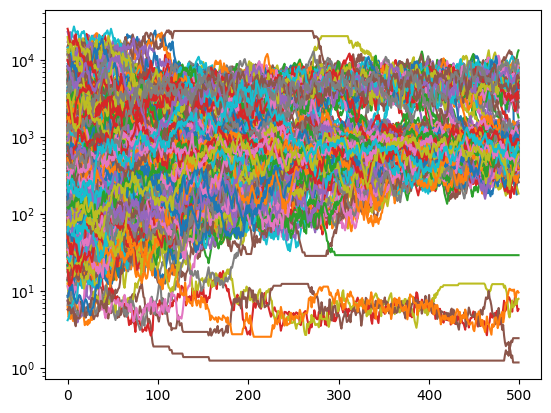

In [95]:
plot_firm_evolutions(small_model_firm_sizes, max_steps, small_firm_model)


In [96]:
print("Sum of size of firms at t=0: ", sum(firm_sizes[0]))
print("Sum of size of firms at t=T: ", sum(firm_sizes[-1]))
print("Sum of size of firms at t=0: ", sum(small_model_firm_sizes[0]))
print("Sum of size of firms at t=T: ", sum(small_model_firm_sizes[-1]))
print("")
print("Big firms win")
print("Max size at t=0:", max(firm_sizes[0]))
print("Max size at t=T:", max(firm_sizes[-1]))
print("Median size at t=0:", np.median(firm_sizes[0]))
print("Median size at t=T:", np.median(firm_sizes[-1]))

print("")
print("Small firms win")
print("Max size at t=0:", max(small_model_firm_sizes[0]))
print("Max size at t=T:", max(small_model_firm_sizes[-1]))
print("Median size at t=0:", np.median(small_model_firm_sizes[0]))
print("Median size at t=T:", np.median(small_model_firm_sizes[-1]))

Sum of size of firms at t=0:  1110017.95850689
Sum of size of firms at t=T:  1110017.958506891
Sum of size of firms at t=0:  1110017.95850689
Sum of size of firms at t=T:  1110017.9585068917

Big firms win
Max size at t=0: 25311.969637388105
Max size at t=T: 463219.90991887345
Median size at t=0: 369.798513325836
Median size at t=T: 1.711810916472591

Small firms win
Max size at t=0: 25311.969637388105
Max size at t=T: 13261.669555863591
Median size at t=0: 369.798513325836
Median size at t=T: 720.5824710470315


## Section 3: Explore the parameter space and make interesting plots.

For example:
- Distribution of firm sizes on y and time on x axis
- Distribution of firm sizes on y and $\gamma$ on x axis
- Distribution of firm sizes on y and $\delta$ on x axis
- Distribution of firm sizes on y and $\sigma$ on x axis

## 1. Firm sizes vs. time

In [97]:
import matplotlib.pyplot as plt
np.random.seed(100)
random.seed(100)
evolution_model = FirmModel(20, 5, 1, 2, .1)
evolution_model_small_firm_advantage = FirmModel(20, 5, 1, 2, .1, large_firm_advantage=False)
max_steps = 200
for i in trange(max_steps):
    evolution_model.step()
    evolution_model_small_firm_advantage.step()

evolution_model_firm_sizes = evolution_model.datacollector.get_model_vars_dataframe()["Firm_sizes"].to_numpy()
evolution_model_small_firm_advantage_firm_sizes = evolution_model_small_firm_advantage.datacollector.get_model_vars_dataframe()["Firm_sizes"].to_numpy()

100%|██████████| 200/200 [00:00<00:00, 2557.32it/s]


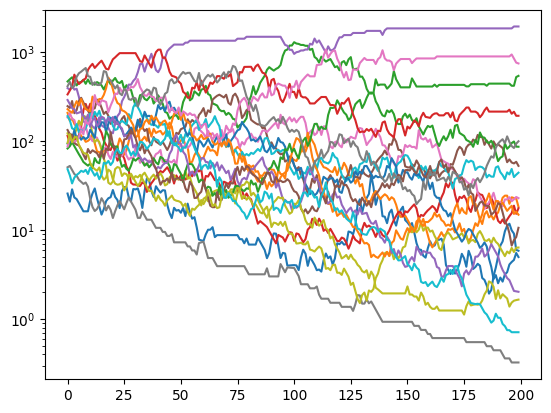

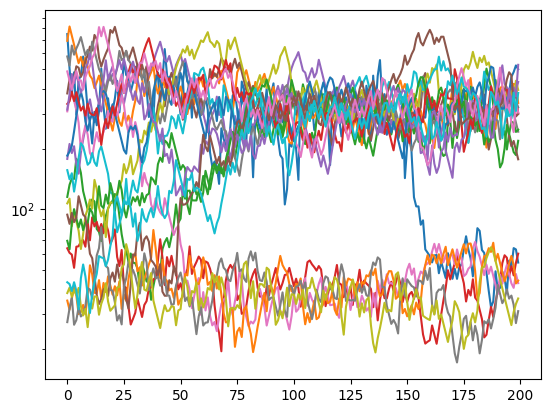

In [98]:
plot_firm_evolutions(evolution_model_firm_sizes, max_steps, evolution_model)
plot_firm_evolutions(evolution_model_small_firm_advantage_firm_sizes, max_steps, evolution_model_small_firm_advantage)

## 2. Firm sizes vs. $\gamma$

In [99]:
np.random.seed(100)
random.seed(100)
max_steps = 200
large_firm_data = []
small_firm_data = []
for i in trange(2, 50, 1):
    gamma = i/100
    large_firm_model = FirmModel(500, 6, 1.5, 2, gamma)
    small_firm_model = FirmModel(500, 6, 1.5, 2, gamma, large_firm_advantage=False)
    for _ in trange(max_steps):
        large_firm_model.step()
        small_firm_model.step()
    large_model_firm_sizes = large_firm_model.datacollector.get_model_vars_dataframe()["Firm_sizes"].to_numpy()
    small_model_firm_sizes = small_firm_model.datacollector.get_model_vars_dataframe()["Firm_sizes"].to_numpy()
    large_firm_data.append(large_model_firm_sizes)
    small_firm_data.append(small_model_firm_sizes)

100%|██████████| 48/48 [05:38<00:00,  7.06s/it]


In [34]:
from scipy.stats import skew

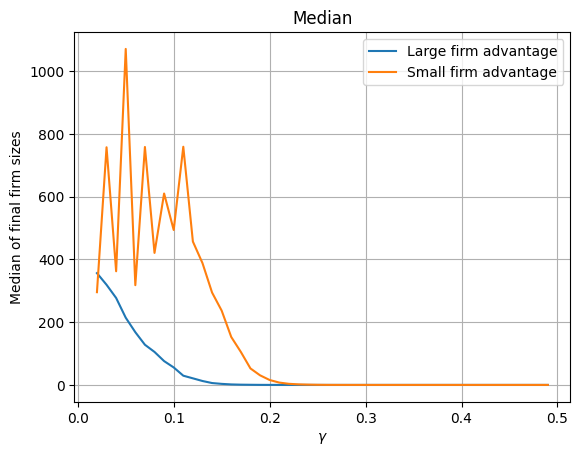

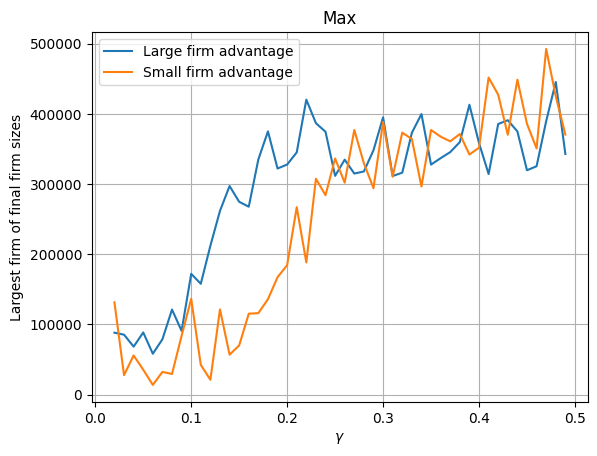

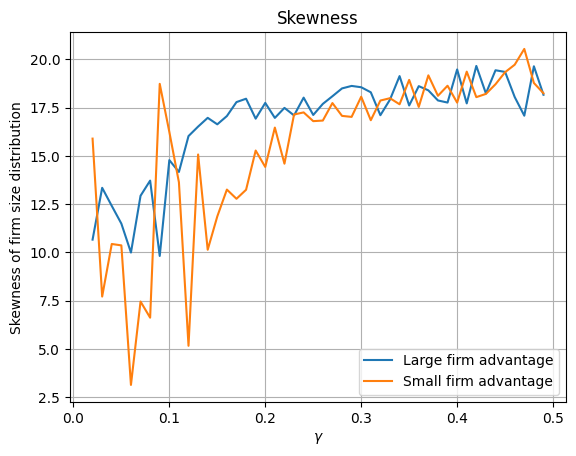

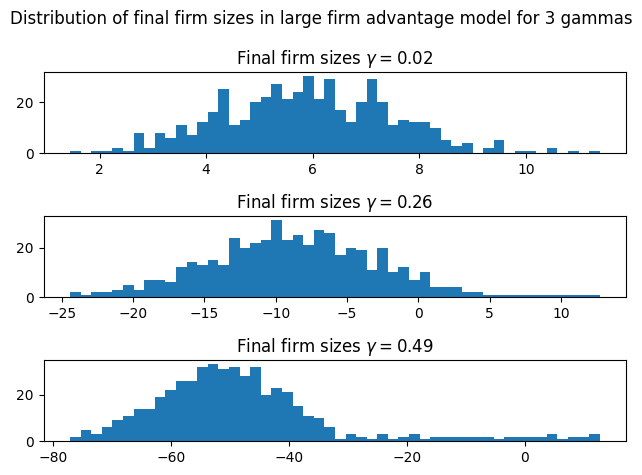

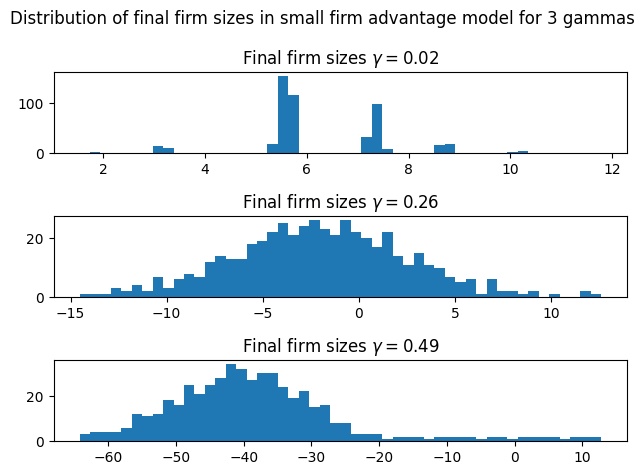

In [100]:
gammas = np.arange(0.02,0.5,0.01)

medians_large_firm = [np.median(gamma_result[-1]) for gamma_result in large_firm_data]
medians_small_firm = [np.median(gamma_result[-1]) for gamma_result in small_firm_data]

max_size_large_firm = [max(gamma_result[-1]) for gamma_result in large_firm_data]
max_size_small_firm = [max(gamma_result[-1]) for gamma_result in small_firm_data]

skewness_large_firm = [skew(gamma_result[-1]) for gamma_result in large_firm_data]
skewness_small_firm = [skew(gamma_result[-1]) for gamma_result in small_firm_data]

plt.figure()
plt.plot(gammas, medians_large_firm, label="Large firm advantage")
plt.plot(gammas, medians_small_firm, label="Small firm advantage")
plt.ylabel("Median of final firm sizes")
plt.xlabel("$\gamma$")
plt.title("Median")
plt.grid(True)
plt.legend()
plt.show()

plt.figure()
plt.plot(gammas, max_size_large_firm, label="Large firm advantage")
plt.plot(gammas, max_size_small_firm, label="Small firm advantage")
plt.ylabel("Largest firm of final firm sizes")
plt.xlabel("$\gamma$")
plt.title("Max")
plt.grid(True)
plt.legend()
plt.show()

plt.figure()
plt.plot(gammas, skewness_large_firm, label="Large firm advantage")
plt.plot(gammas, skewness_small_firm, label="Small firm advantage")
plt.ylabel("Skewness of firm size distribution")
plt.xlabel("$\gamma$")
plt.title("Skewness")
plt.grid(True)
plt.legend()
plt.show()

fig, axs = plt.subplots(3,1)
fig.suptitle("Distribution of final firm sizes in large firm advantage model for 3 gammas")
axs[0].hist(np.log(large_firm_data[0][-1]), bins=50)
axs[0].set_title(f"Final firm sizes $\gamma = {gammas[0]}$")
axs[1].hist(np.log(large_firm_data[len(large_firm_data)//2][-1]), bins=50)
axs[1].set_title(f"Final firm sizes $\gamma = {str(round(gammas[len(large_firm_data)//2], 2))}$")
axs[2].hist(np.log(large_firm_data[-1][-1]), bins=50)
axs[2].set_title(f"Final firm sizes $\gamma = {str(round(gammas[-1],2))}$")
fig.tight_layout()
plt.show()

fig, axs = plt.subplots(3,1)
fig.suptitle("Distribution of final firm sizes in small firm advantage model for 3 gammas")
axs[0].hist(np.log(small_firm_data[0][-1]), bins=50)
axs[0].set_title(f"Final firm sizes $\gamma = {gammas[0]}$")
axs[1].hist(np.log(small_firm_data[len(small_firm_data)//2][-1]), bins=50)
axs[1].set_title(f"Final firm sizes $\gamma = {str(round(gammas[len(small_firm_data)//2], 2))}$")
axs[2].hist(np.log(small_firm_data[-1][-1]), bins=50)
axs[2].set_title(f"Final firm sizes $\gamma = {str(round(gammas[-1],2))}$")
fig.tight_layout()
plt.show()


## 3. Firm sizes vs $\delta$

In [102]:
np.random.seed(100)
random.seed(100)
max_steps = 200
large_firm_delta_data = []
small_firm_delta_data = []
for i in trange(11, 30, 1):
    delta = i/10
    large_firm_delta_model = FirmModel(500, 6, 1.5, delta, 0.1)
    small_firm_delta_model = FirmModel(500, 6, 1.5, delta, 0.1, large_firm_advantage=False)
    for _ in trange(max_steps):
        large_firm_delta_model.step()
        small_firm_delta_model.step()
    large_delta_model_firm_sizes = large_firm_delta_model.datacollector.get_model_vars_dataframe()["Firm_sizes"].to_numpy()
    small_delta_model_firm_sizes = small_firm_delta_model.datacollector.get_model_vars_dataframe()["Firm_sizes"].to_numpy()
    large_firm_delta_data.append(large_firm_delta_model.datacollector.get_model_vars_dataframe()["Firm_sizes"].to_numpy())
    small_firm_delta_data.append(small_firm_delta_model.datacollector.get_model_vars_dataframe()["Firm_sizes"].to_numpy())

100%|██████████| 19/19 [01:27<00:00,  4.59s/it]


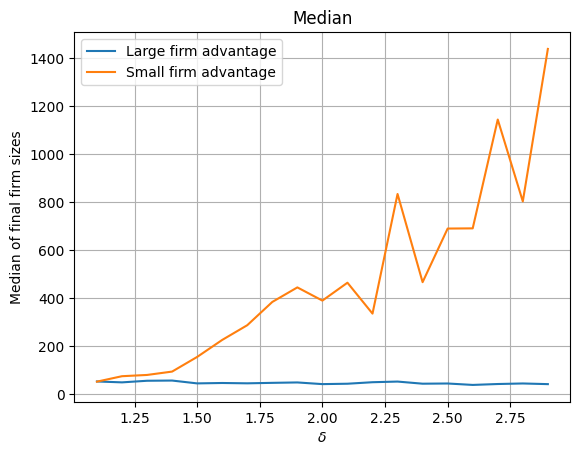

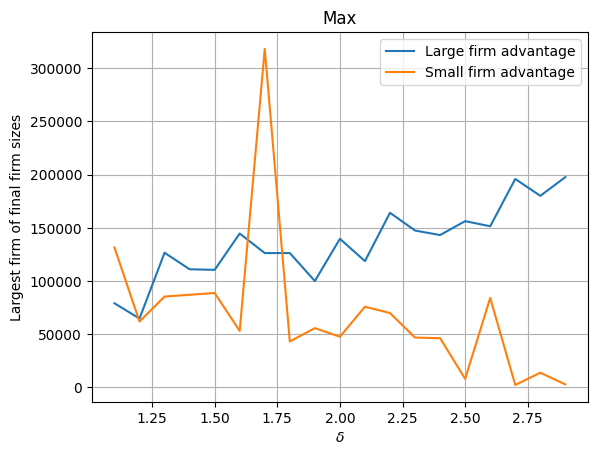

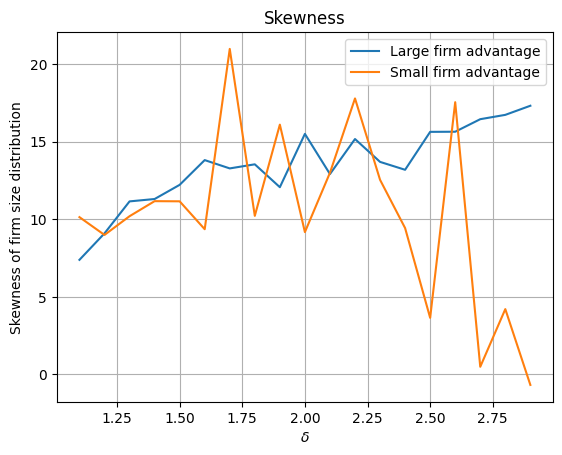

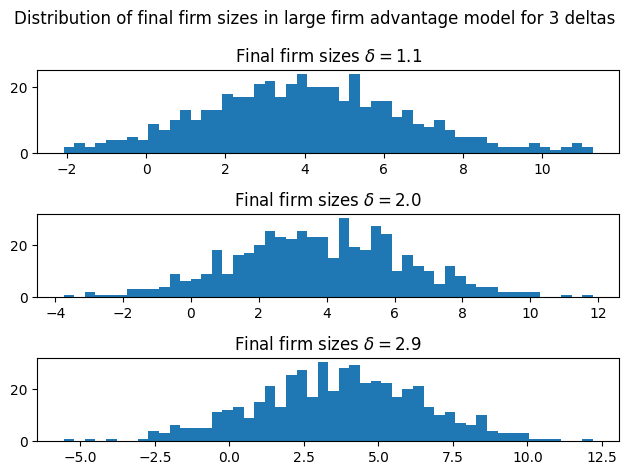

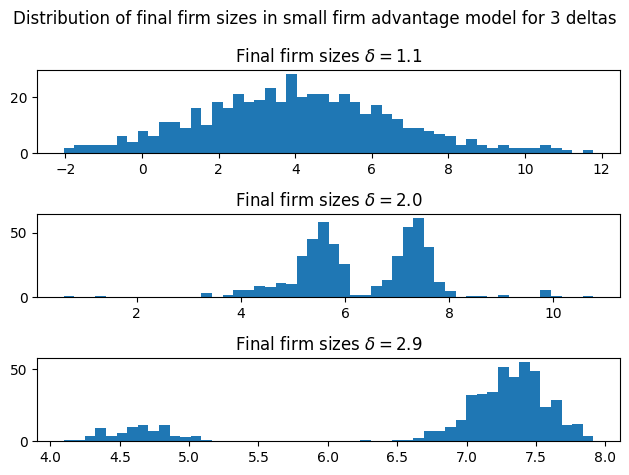

In [103]:
deltas = np.arange(1.1,3,0.1)

medians_large_firm_delta = [np.median(delta_result[-1]) for delta_result in large_firm_delta_data]
medians_small_firm_delta = [np.median(delta_result[-1]) for delta_result in small_firm_delta_data]

max_size_small_firm_delta = [max(delta_result[-1]) for delta_result in small_firm_delta_data]
max_size_large_firm_delta = [max(delta_result[-1]) for delta_result in large_firm_delta_data]

skewness_large_firm_delta = [skew(delta_result[-1]) for delta_result in large_firm_delta_data]
skewness_small_firm_delta = [skew(delta_result[-1]) for delta_result in small_firm_delta_data]

plt.figure()
plt.plot(deltas, medians_large_firm_delta, label="Large firm advantage")
plt.plot(deltas, medians_small_firm_delta, label="Small firm advantage")
plt.ylabel("Median of final firm sizes")
plt.xlabel("$\delta$")
plt.title("Median")
plt.grid(True)
plt.legend()
plt.show()

plt.figure()
plt.plot(deltas, max_size_large_firm_delta, label="Large firm advantage")
plt.plot(deltas, max_size_small_firm_delta, label="Small firm advantage")
plt.ylabel("Largest firm of final firm sizes")
plt.xlabel("$\delta$")
plt.title("Max")
plt.grid(True)
plt.legend()
plt.show()

plt.figure()
plt.plot(deltas, skewness_large_firm_delta, label="Large firm advantage")
plt.plot(deltas, skewness_small_firm_delta, label="Small firm advantage")
plt.ylabel("Skewness of firm size distribution")
plt.xlabel("$\delta$")
plt.title("Skewness")
plt.grid(True)
plt.legend()
plt.show()

fig, axs = plt.subplots(3,1)
fig.suptitle("Distribution of final firm sizes in large firm advantage model for 3 deltas")
axs[0].hist(np.log(large_firm_delta_data[0][-1]), bins=50)
axs[0].set_title(f"Final firm sizes $\delta = {deltas[0]}$")
axs[1].hist(np.log(large_firm_delta_data[len(large_firm_delta_data)//2][-1]), bins=50)
axs[1].set_title(f"Final firm sizes $\delta = {str(round(deltas[len(large_firm_delta_data)//2], 2))}$")
axs[2].hist(np.log(large_firm_delta_data[-1][-1]), bins=50)
axs[2].set_title(f"Final firm sizes $\delta = {str(round(deltas[-1],2))}$")
fig.tight_layout()
plt.show()

fig, axs = plt.subplots(3,1)
fig.suptitle("Distribution of final firm sizes in small firm advantage model for 3 deltas")
axs[0].hist(np.log(small_firm_delta_data[0][-1]), bins=50)
axs[0].set_title(f"Final firm sizes $\delta = {deltas[0]}$")
axs[1].hist(np.log(small_firm_delta_data[len(small_firm_delta_data)//2][-1]), bins=50)
axs[1].set_title(f"Final firm sizes $\delta = {str(round(deltas[len(small_firm_delta_data)//2], 2))}$")
axs[2].hist(np.log(small_firm_delta_data[-1][-1]), bins=50)
axs[2].set_title(f"Final firm sizes $\delta = {str(round(deltas[-1],2))}$")
fig.tight_layout()
plt.show()

### Interesting convergence into different firm size classes for high delta and small firm advantage

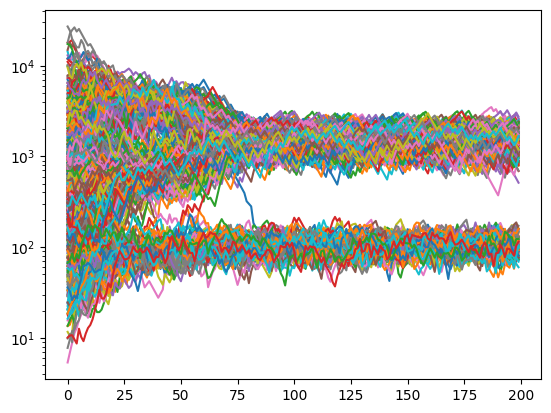

In [105]:
plot_firm_evolutions(small_firm_delta_data[-1], max_steps, small_firm_delta_model)